# Getting started with PRISMO

PRISMO is a framework for factor analysis of multimodal data, with a focus on single-cell omics, representing an observed data matrix $\mat{Y}$ as a product of a low-rank factor matrix $\mat{Z}$ and a low-rank weight matrix $\mat{W}$: $\mat{Y} \approx \mat{Z} \mat{W}$.
It is essentially a synthesis of MOFA{cite:p}`pmid29925568,pmid32393329`, MEFISTO{cite:p}`pmid35027765`, MuVI{cite:p}`pmlr-v206-qoku23a`, nonnegative matrix factorization, and NSF{cite:p}`pmid36587187`.
It natively supports [MuData](https://mudata.readthedocs.io) and [AnnData](https://anndata.readthedocs.io) objects, integrating into the wider [scverse](https://scverse.org) ecosystem.

For this notebook, we will use the [pbmc3k dataset by 10x Genomics](https://www.10xgenomics.com/resources/datasets/pbmc-from-a-healthy-donor-granulocytes-removed-through-cell-sorting-3-k-1-standard-2-0-0), conveniently packaged in the `mudatasets` package.
The dataset contains 10 000 single cells profiled with the 10x multiome assay, capturing gene expression (scRNAseq) and chromatin accessibility (scATACseq).

In [1]:
import mudata as md
import mudatasets as mds
import muon as mu
import prismo as pr
import scanpy as sc
from plotnine import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
theme_set(theme_bw())
md.set_options(display_style="html", display_html_expand=0);

In [3]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
mdata = mds.load("pbmc3k_multiome")

■ File filtered_feature_bc_matrix.h5 from pbmc3k_multiome has been found at /home/kats/mudatasets/pbmc3k_multiome/filtered_feature_bc_matrix.h5
■ Checksum is validated (md5) for filtered_feature_bc_matrix.h5
■ Loading filtered_feature_bc_matrix.h5...


/data/ilia/envs/famo/lib/python3.11/site-packages/mudatasets/core.py:203: UserWarning: Dataset is in the 10X .h5 format and can't be loaded as backed.
/data/ilia/envs/famo/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/data/ilia/envs/famo/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added `interval` annotation for features from /home/kats/mudatasets/pbmc3k_multiome/filtered_feature_bc_matrix.h5


/data/ilia/mudata/src/mudata/_core/mudata.py:933: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
mdata.var_names_make_unique()
mdata

rna,bool,numpy.ndarray,
atac,bool,numpy.ndarray,


## Preprocessing

We first perform the basic preprocessing steps outlined in the [muon tutorial](inv:muon-tutorials#/single-cell-rna-atac/pbmc10k/1-gene-expression-processing.ipynb) to remove undetected genes and poor-quality cells.

In [6]:
rna = mdata["rna"]
rna.var["mt"] = rna.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    rna, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
mu.pp.filter_var(rna, "n_cells_by_counts", lambda x: x >= 3)
mu.pp.filter_obs(rna, "n_genes_by_counts", lambda x: (x >= 200) & (x < 5000))

mu.pp.filter_obs(rna, "total_counts", lambda x: x < 15000)
mu.pp.filter_obs(rna, "pct_counts_mt", lambda x: x < 20)

atac = mdata.mod["atac"]
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)
mu.pp.filter_var(atac, "n_cells_by_counts", lambda x: x >= 10)
mu.pp.filter_obs(atac, "n_genes_by_counts", lambda x: (x >= 2000) & (x <= 15000))
mu.pp.filter_obs(atac, "total_counts", lambda x: (x >= 4000) & (x <= 40000))

We further normalize the data and subselect highly variable genes that will be used in the analysis.

In [7]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)

mu.atac.pp.tfidf(atac, scale_factor=1e4)
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=0.5)
mu.pp.filter_var(atac, atac.var_names[atac.var.highly_variable])

mdata.update()

In [8]:
mdata

MuData object with n_obs × n_vars = 2695 × 42241
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  2 modalities
    rna:	2636 x 21256
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
    atac:	2450 x 20985
      obs:	'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'

## Fitting a model

Creating a [PRISMO](#prismo.PRISMO) object automatically fits the model using the specified parameters.
A basic understanding of the [model](#modeldescription) is required to correctly set the parameters for a given dataset.

The main deviation from the PRISMO defaults that we will make for the pbmc10k dataset is using a negative binomial likelihood, which is more appropriate for count data than the default Gaussian likelihood.
With default settings, PRISMO will plot the number of observations in each view and group.
This can be turned off by customizing [](#prismo.DataOptions).
PRISMO will also automatically save the final model after training which can later be loaded with [](#prismo.PRISMO.load).
The name of the saved file can be changed in [](#prismo.TrainingOptions).

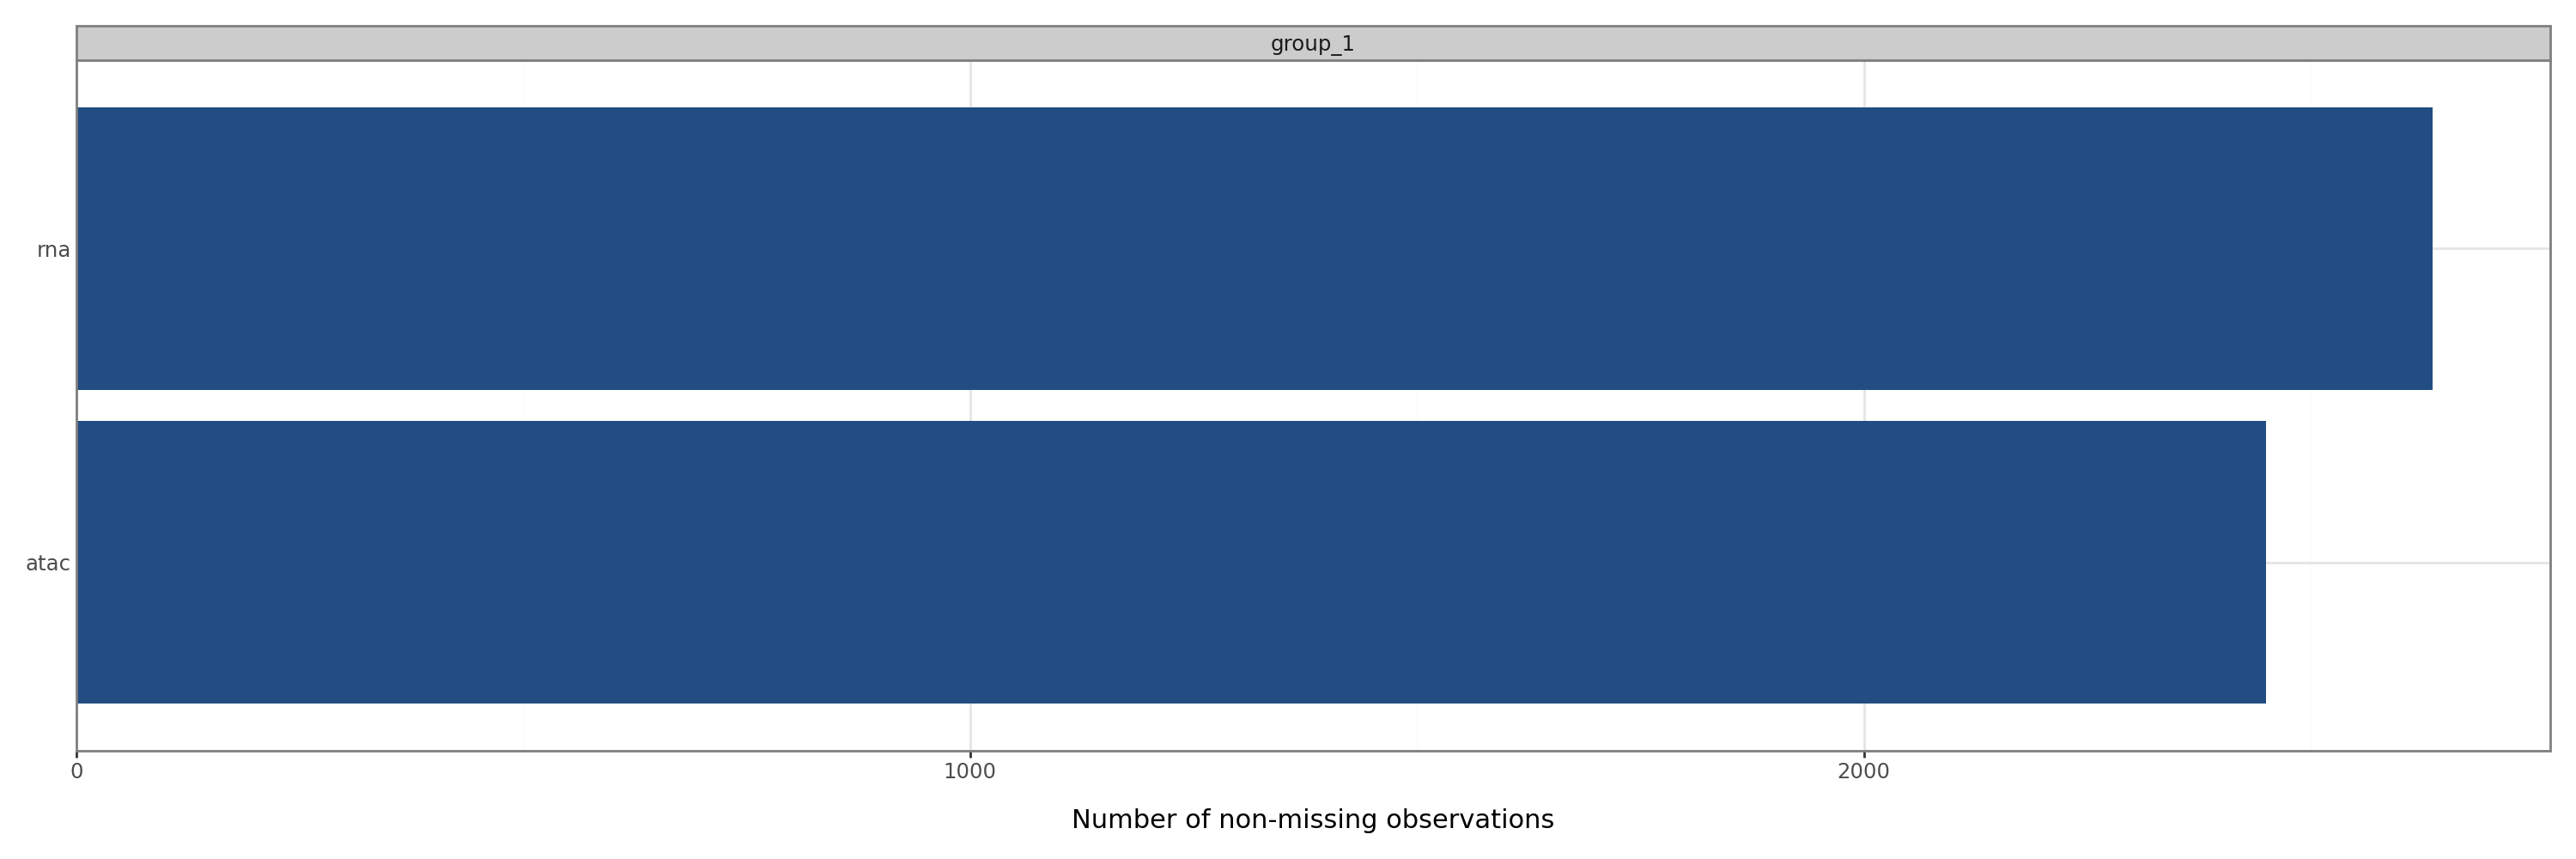

INFO	Using provided likelihood for all views.
INFO	Checking compatibility of provided likelihoods with data.
INFO	Using these likelihoods: rna: Normal; atac: Normal
INFO	Setting training seed to `42`.
INFO	Initializing factors using `random` method...
INFO	Decaying learning rate over 20000 iterations.
INFO	Cleaning parameter store.
INFO 	 Guessed max_plate_nesting = 3
INFO	Epoch:       0 | Time:       1.59s | Loss:  185955.11
INFO	Epoch:     100 | Time:      43.52s | Loss:  167302.40
INFO	Epoch:     200 | Time:      85.28s | Loss:  156357.14
INFO	Epoch:     300 | Time:     127.18s | Loss:  149318.33
INFO	Epoch:     400 | Time:     169.08s | Loss:  144252.33
INFO	Epoch:     500 | Time:     211.27s | Loss:  140719.69
INFO	Epoch:     600 | Time:     253.28s | Loss:  138238.21
INFO	Epoch:     700 | Time:     295.28s | Loss:  136731.65
INFO	Epoch:     800 | Time:     337.11s | Loss:  135636.66
INFO	Epoch:     900 | Time:     379.11s | Loss:  135231.55
INFO	Epoch:    1000 | Time:     421.09s

In [9]:
model = pr.PRISMO(
    mdata,
    pr.ModelOptions(n_factors=15, likelihoods="Normal"),
    pr.TrainingOptions(batch_size=1000, seed=42),
)

We can plot the loss curve to get an overview of the training process:

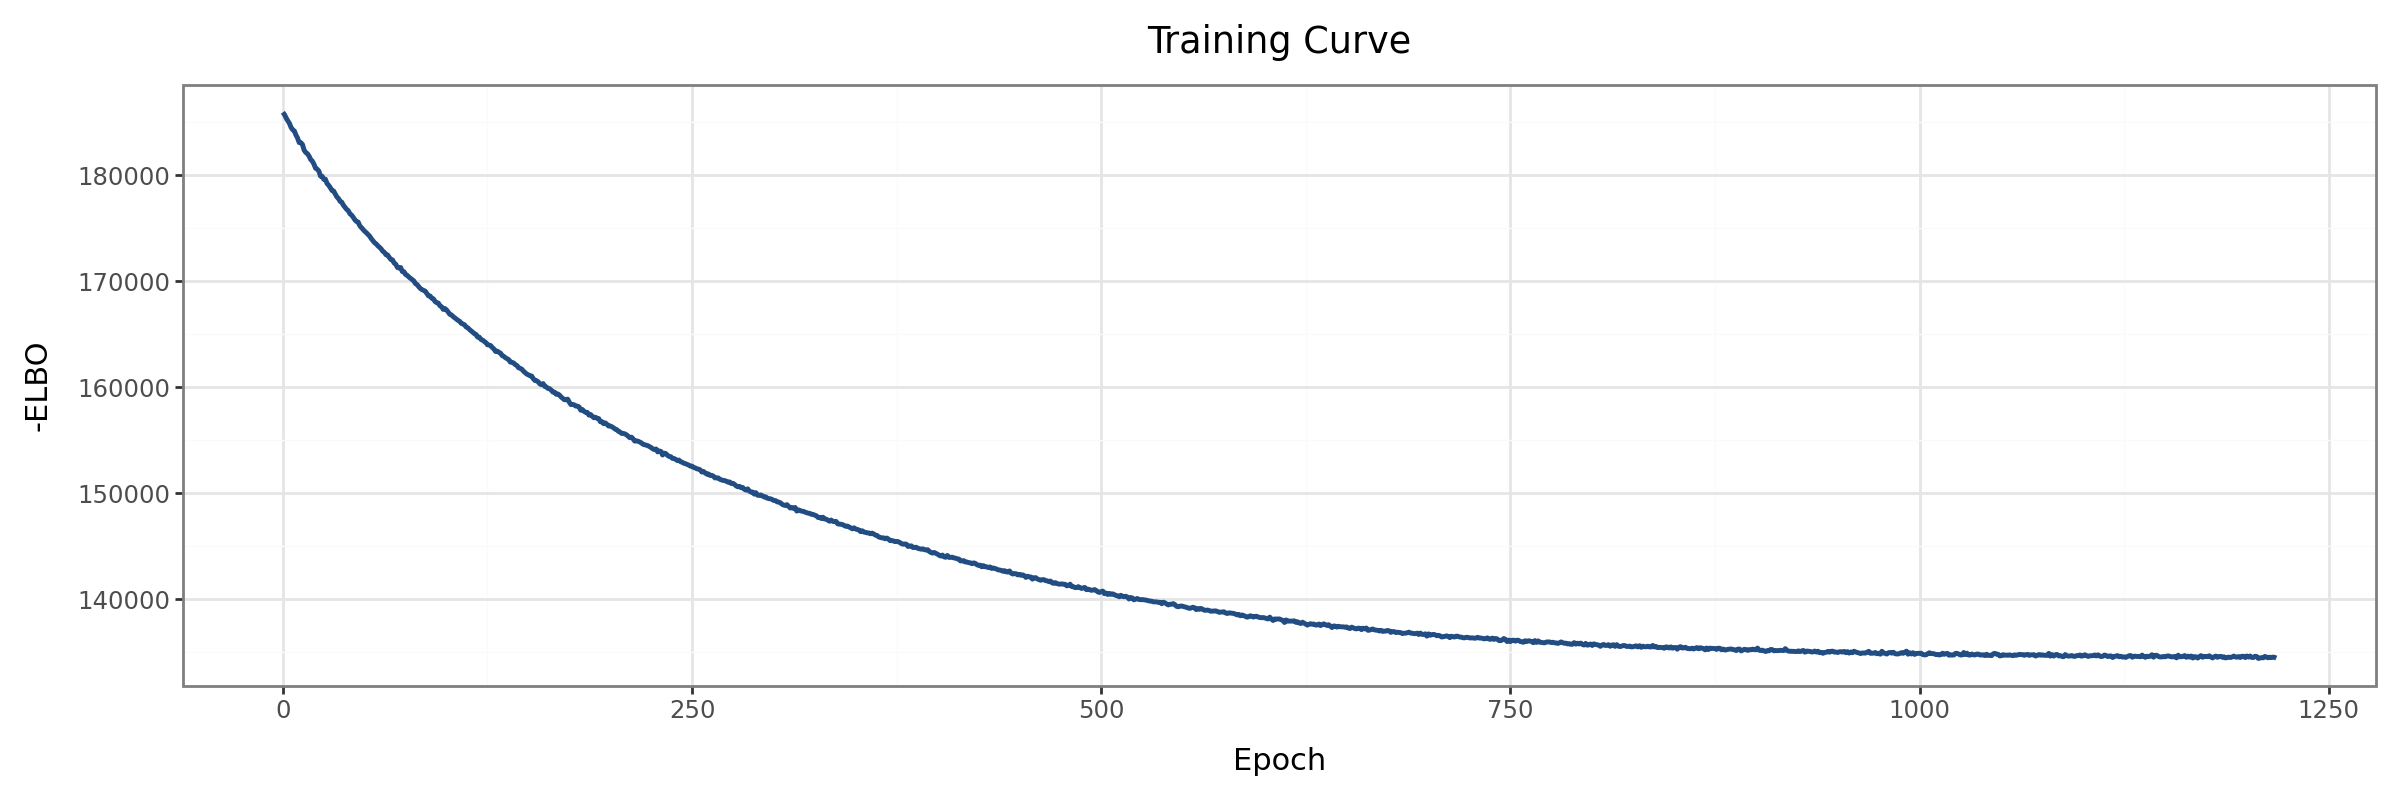

In [10]:
pr.pl.training_curve(model)

## Analysing the model
The trained model can now be analysed to assess its quality and discover relevant biology.
First, we plot the correlations between factors, which should be as low as possible: We want factors to be uncorrelated, as each factor should capture a different aspect of the data.

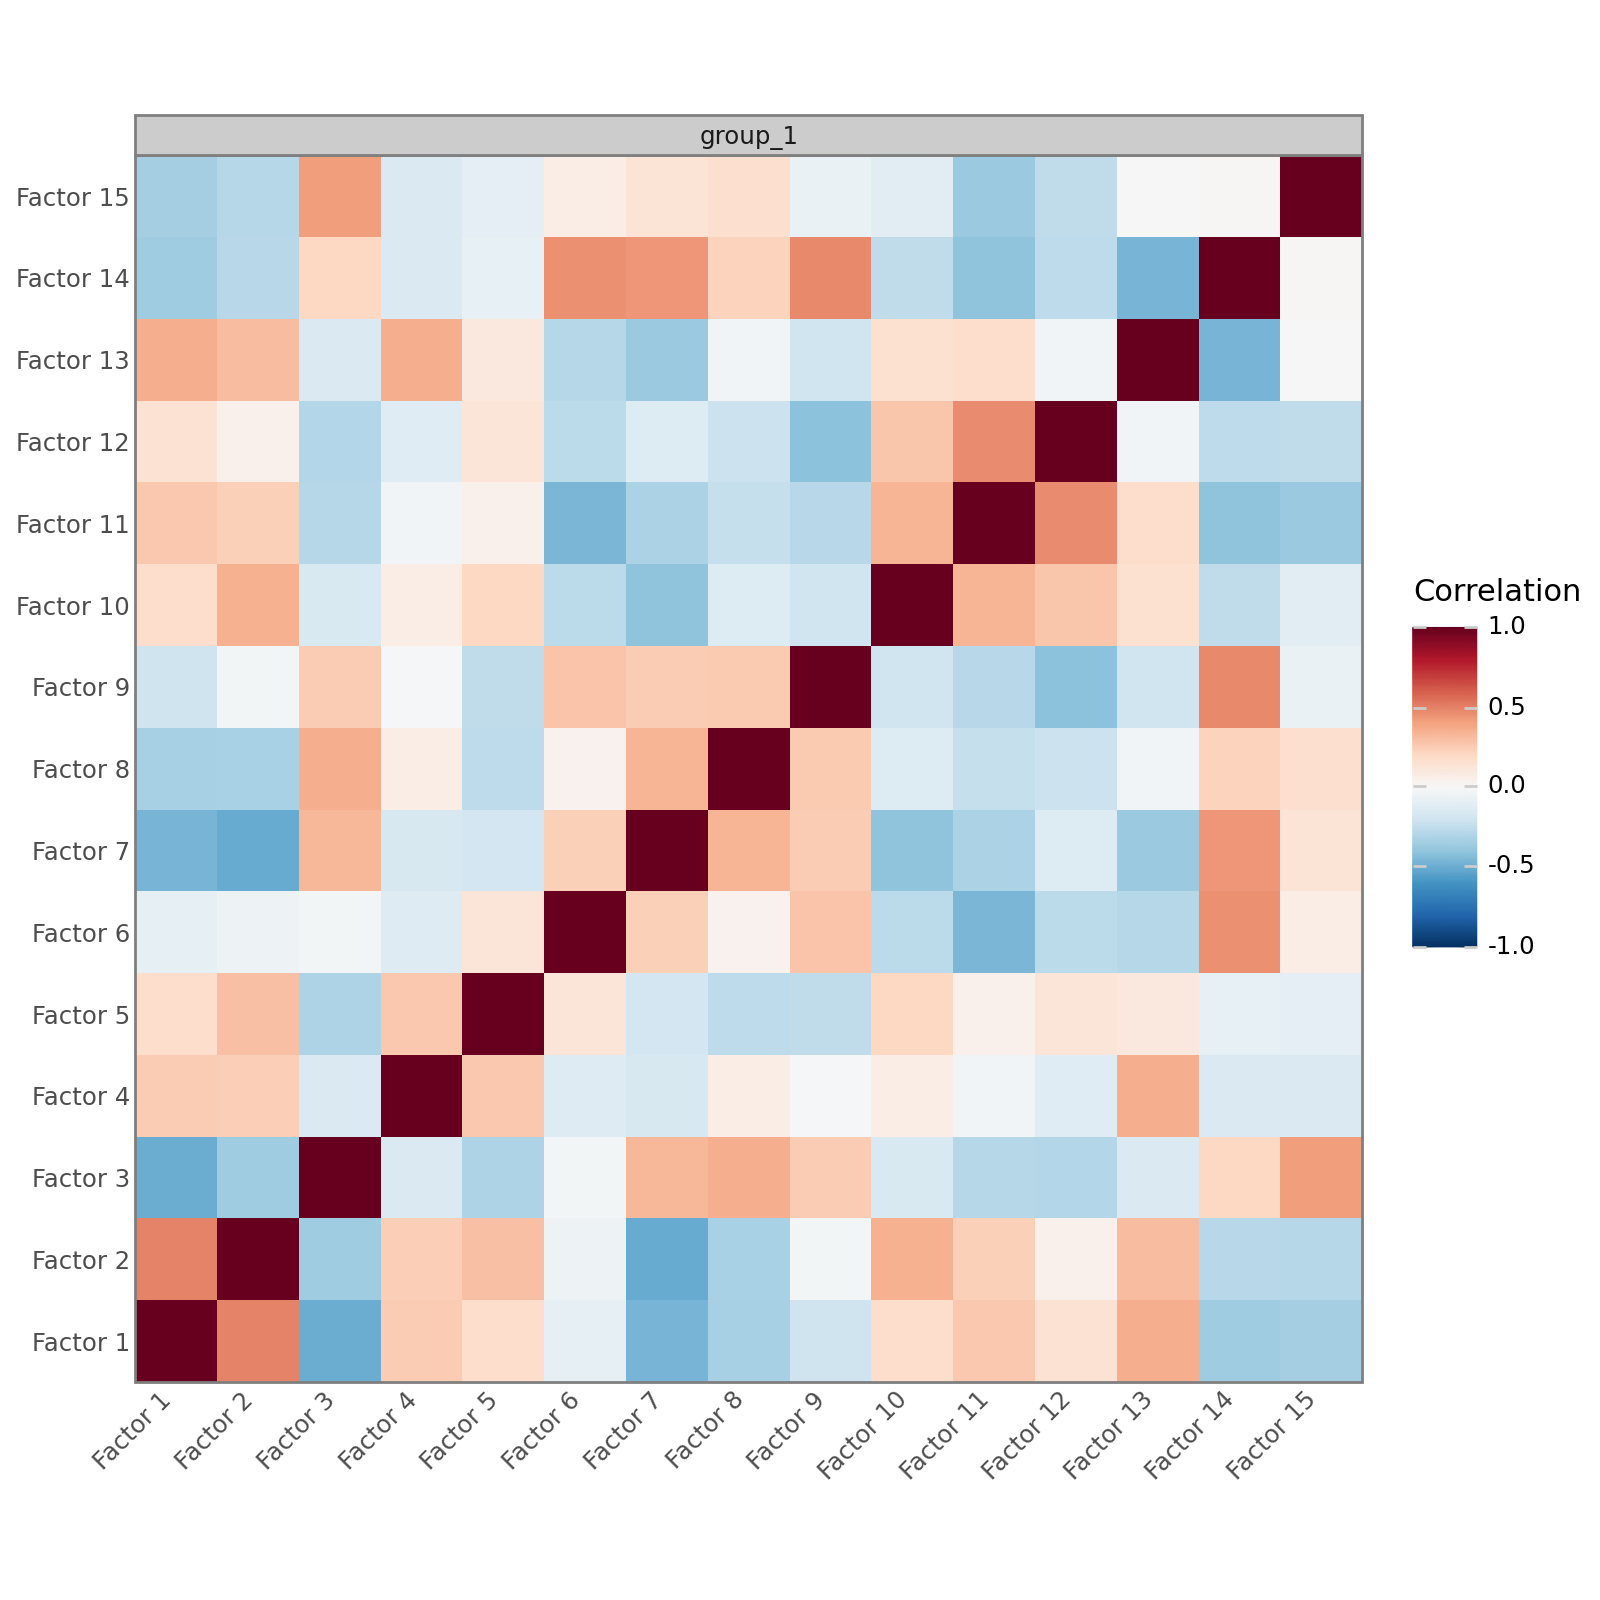

In [11]:
pr.pl.factor_correlation(model)

This is not ideal, but good enough for a first look at the data.
We can now plot the fraction of variance in the data explained by each factor to determine the most important factors.
Note that for non-Normal likelihoods, these values are approximate.

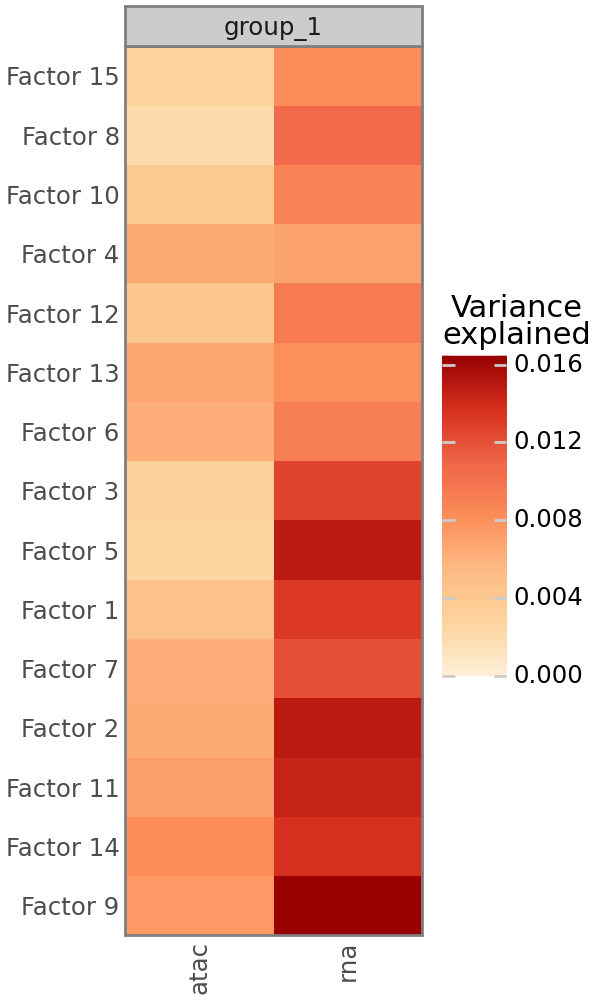

In [12]:
pr.pl.variance_explained(model)

We can plot the most important genes per factor to get an idea of what each factor represents.
This plot aggregates over all views.

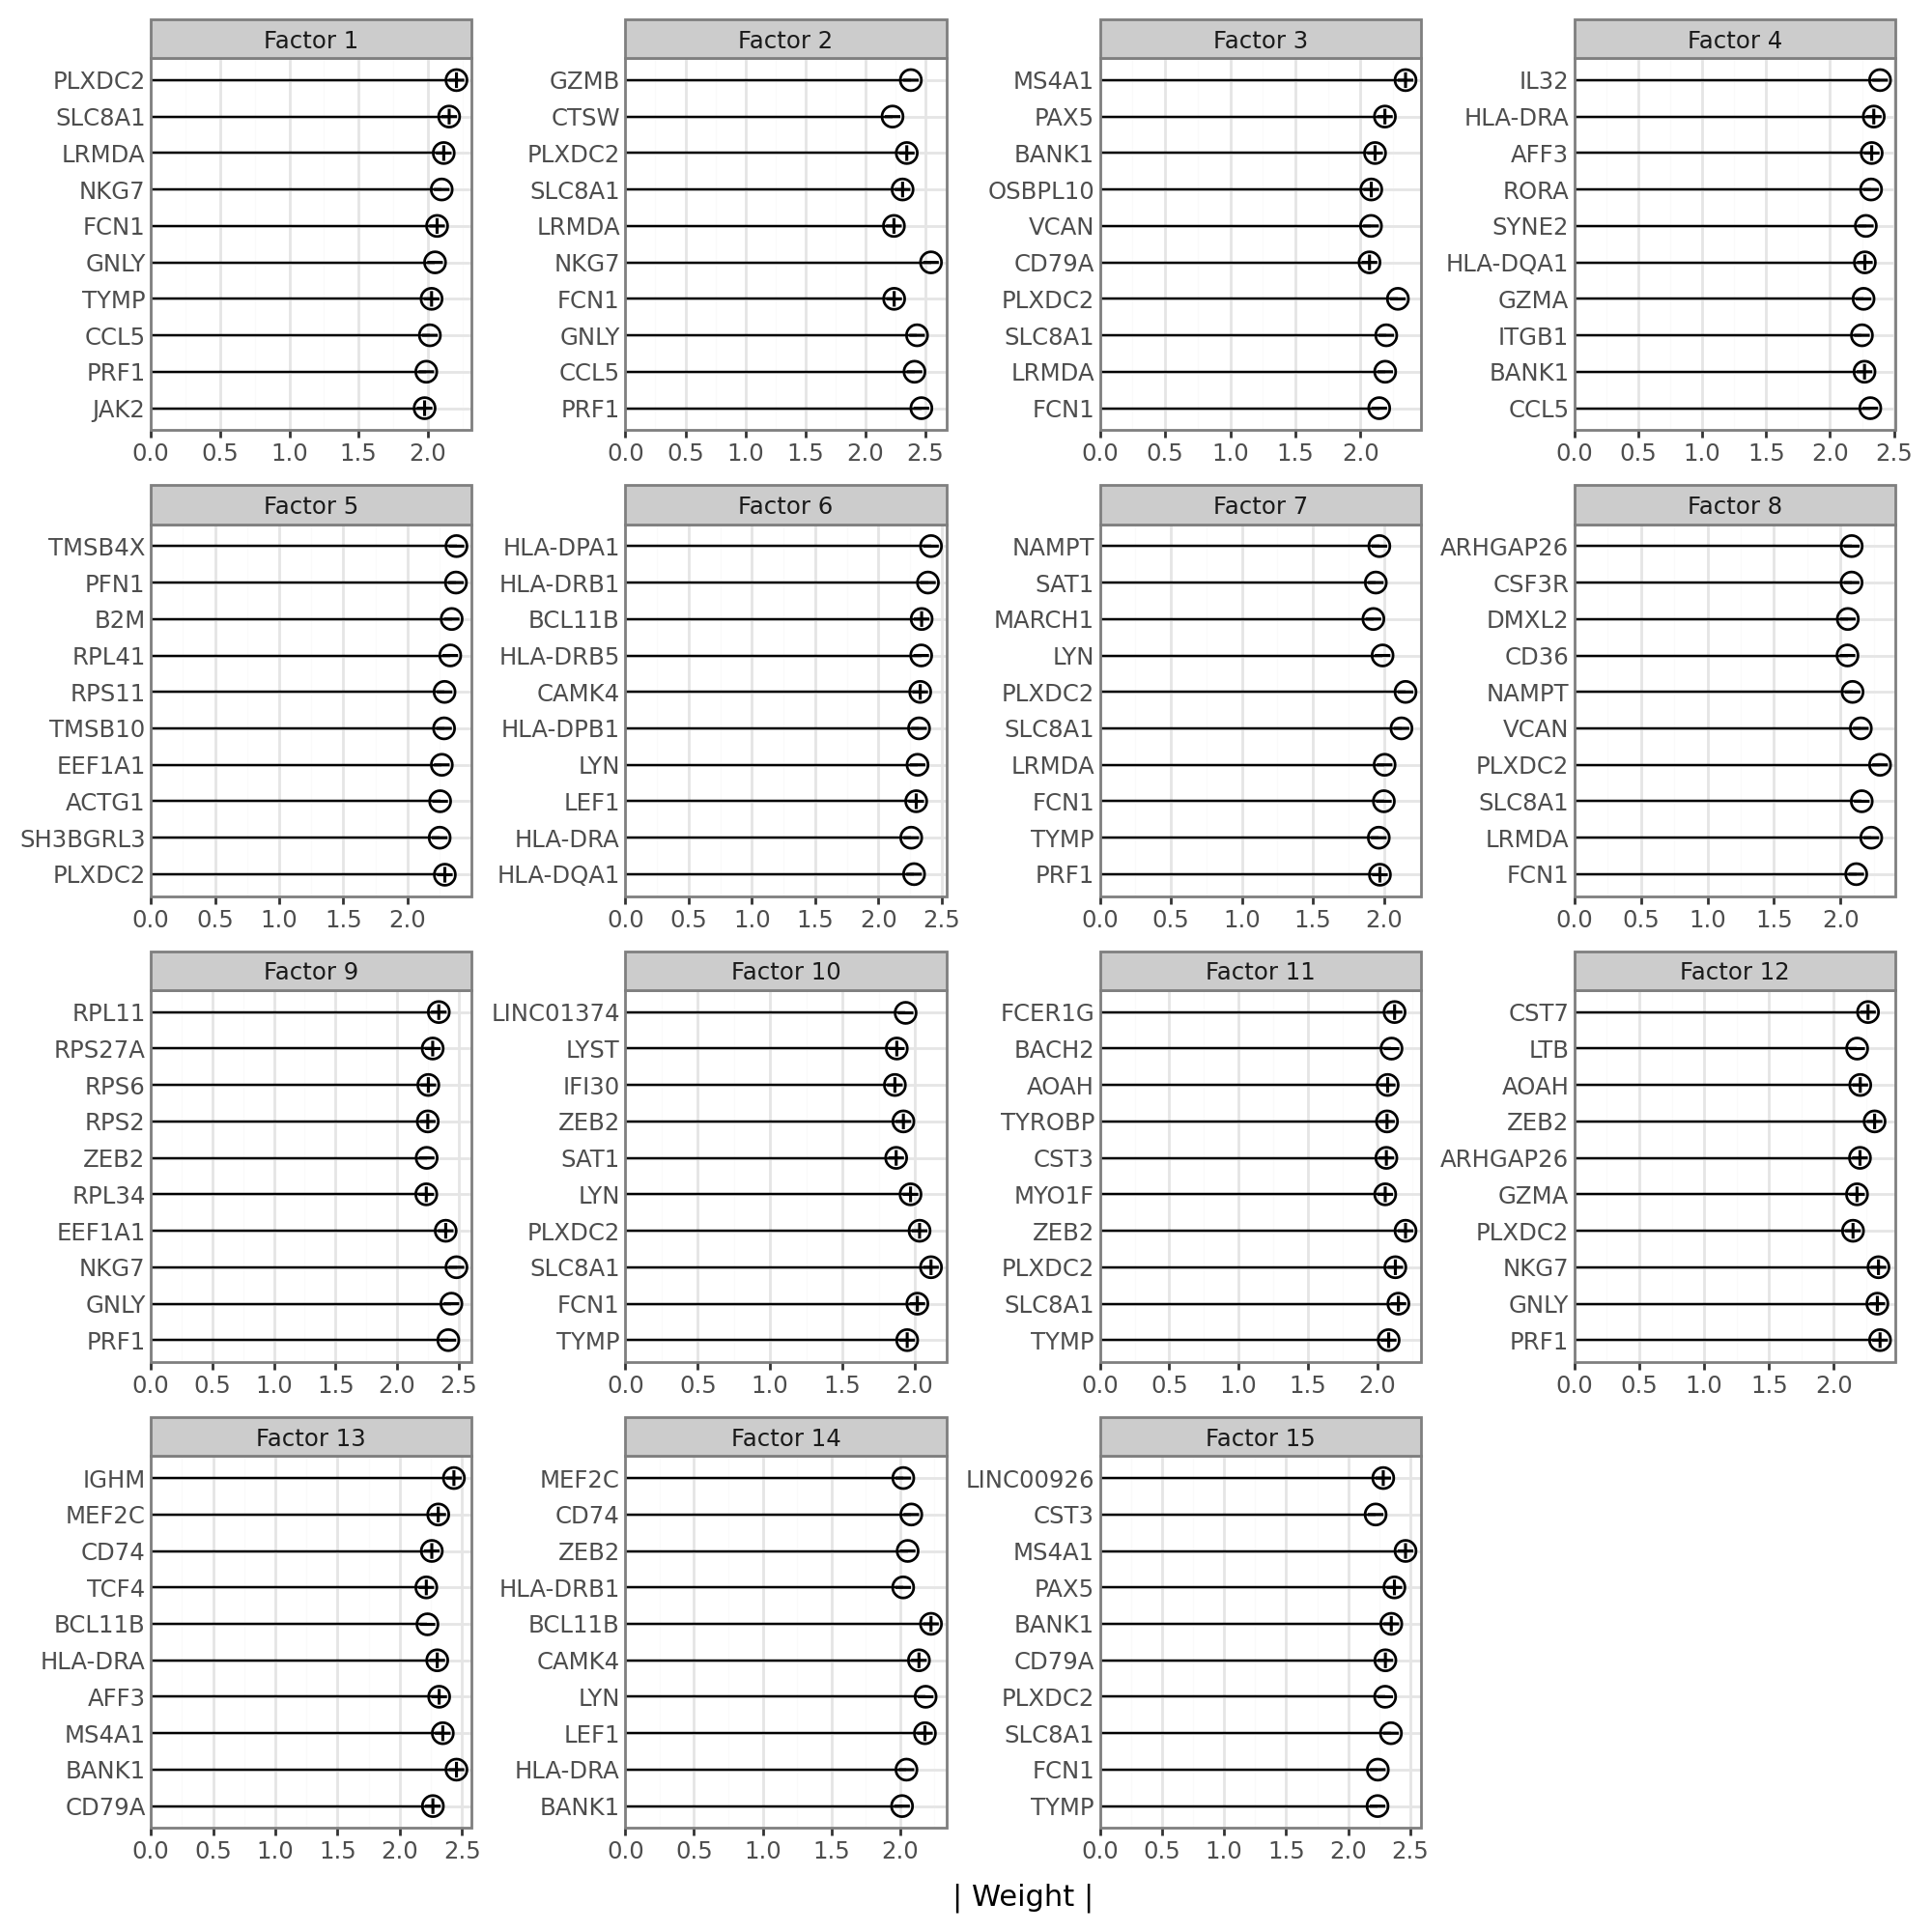

In [13]:
pr.pl.top_weights(model, figsize=(10, 10))

It appears that the most important features are all from the RNA dataset.
We can use a different plotting function to get the top weights individually for each view.

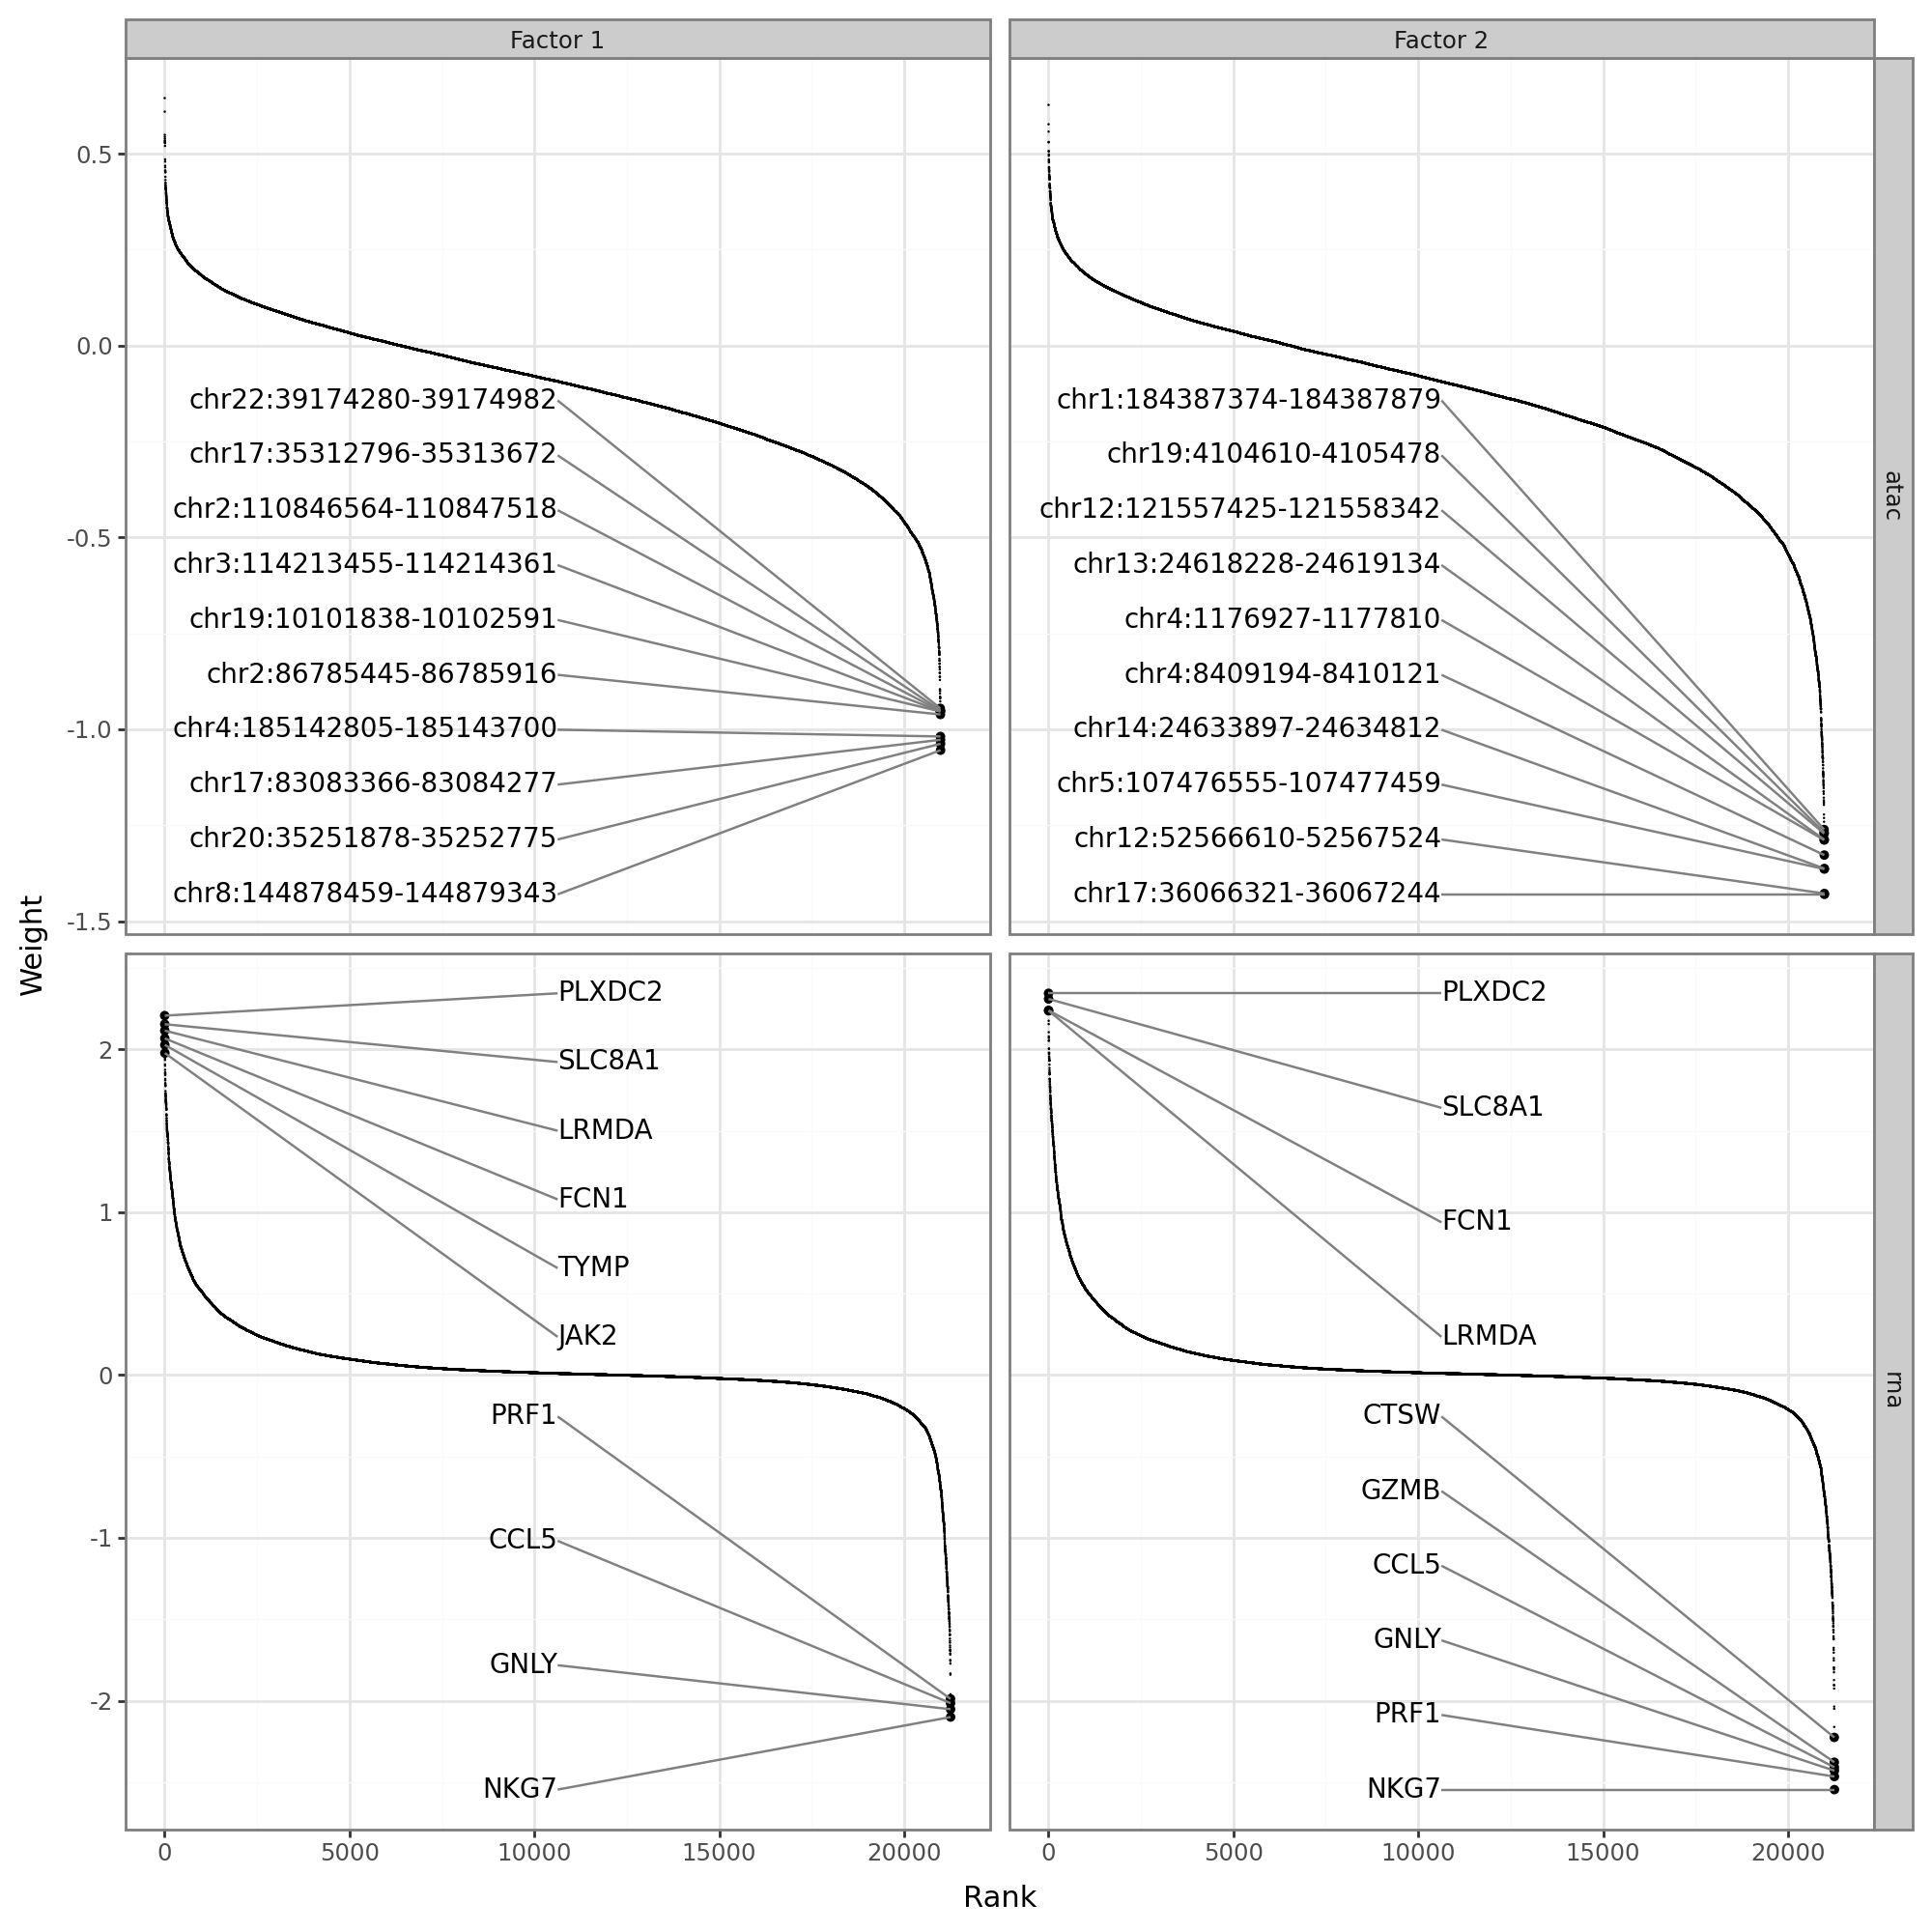

In [14]:
pr.pl.weights(model, factors=(1, 2), figsize=(10, 10))

We can also plot factors agains each other.
This may be useful to define clusters of cells with similar factor values.

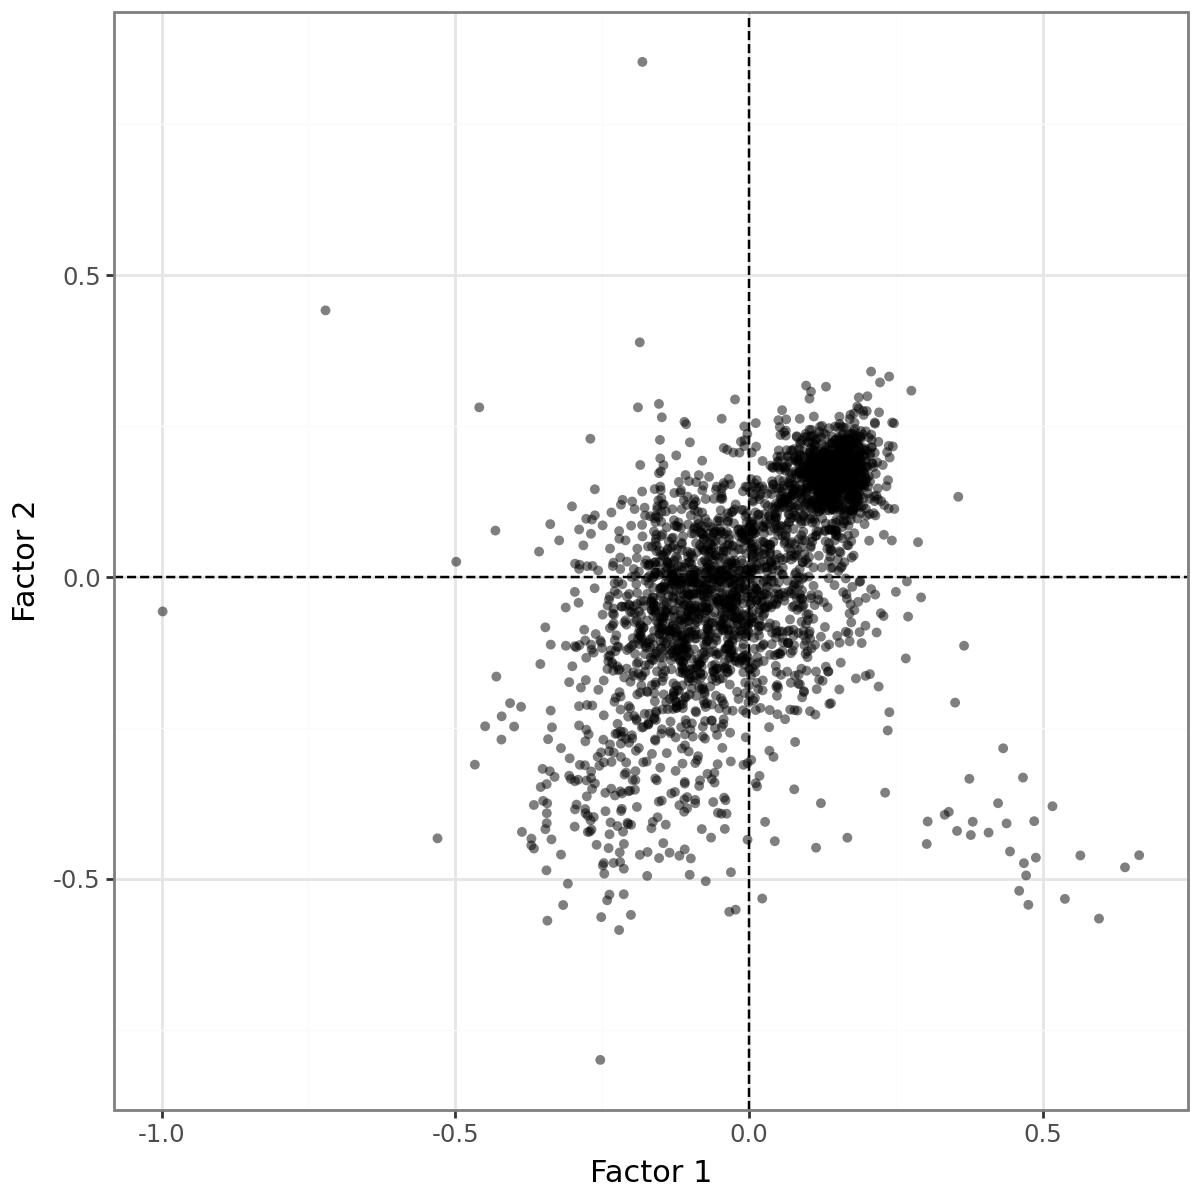

In [15]:
pr.pl.factors_scatter(model, 1, 2, alpha=0.5)

Of course, PRISMO does not and cannot provide all imaginable analysis functions.
It thus provides methods to access the factor and weight values, such that they can be used for manual analysis.

In [16]:
weights = model.get_weights()
factors = model.get_factors()

weights["rna"]

,AL627309.1,AL627309.5,AL627309.4,AL669831.2,LINC01409,LINC01128,LINC00115,FAM41C,AL645608.2,SAMD11,...,MT-ND6,MT-CYB,AC145212.1,MAFIP,AC011043.1,AL354822.1,AL592183.1,AC240274.1,AC004556.3,AC007325.4
Factor 1,0.021068,0.119951,0.028762,0.027466,-0.078983,-0.038371,0.053893,-0.011316,0.013348,0.012995,...,0.041555,-0.144013,-0.001667,0.024144,-0.017053,-0.028189,0.200504,-0.063999,-0.131190,-0.050983
Factor 2,0.039453,0.195063,-0.018421,-0.014127,0.014879,0.005849,0.011534,-0.052191,-0.005954,0.033996,...,0.005084,-0.036464,0.016008,-0.038248,-0.001479,0.008847,-0.066131,0.088708,0.009378,0.058434
Factor 3,-0.021072,-0.257705,-0.000356,-0.043706,-0.025409,0.167202,0.024191,-0.052179,-0.000347,0.018416,...,0.329767,0.586821,0.013088,0.025623,0.016035,0.051025,0.294732,0.002180,0.141158,-0.065752
Factor 4,-0.000411,-0.103070,-0.002968,-0.009468,-0.035967,0.306335,-0.061155,0.048232,0.000016,-0.008983,...,0.293246,0.191531,0.004351,-0.000052,-0.003763,0.005193,-0.035381,0.025162,0.046568,0.000354
Factor 5,0.015720,0.353411,0.053754,0.019716,0.065489,-0.069241,0.045420,-0.013409,0.011944,-0.007426,...,-0.645734,0.489765,0.012571,-0.029556,-0.001101,-0.037601,-0.343922,-0.025023,-0.227126,-0.004208
Factor 6,0.018739,0.137717,0.009604,-0.007989,0.150570,0.101919,-0.066260,-0.036770,0.010021,-0.020507,...,-0.934628,-0.395383,-0.004586,0.066579,-0.014354,-0.050997,-0.022922,-0.053900,-0.013657,0.025061
Factor 7,-0.045851,-0.132138,-0.025445,0.012827,0.065615,0.131811,-0.111293,-0.012802,-0.010766,-0.006163,...,0.182963,0.226055,0.054403,-0.018097,0.003352,-0.013138,0.014115,0.041526,-0.058413,0.020467
Factor 8,-0.050844,-0.256210,-0.028277,0.023668,0.165692,-0.120496,0.070885,0.032024,-0.013948,0.027588,...,-0.055429,-0.093975,0.043761,0.046377,-0.018682,-0.063563,0.159697,0.088369,0.044607,-0.079898
Factor 9,-0.063959,-0.131491,-0.020206,-0.005764,-0.088273,-0.113666,0.072360,-0.030909,-0.004823,-0.039925,...,0.117373,0.716690,-0.018968,-0.003597,0.020600,0.007722,-0.200105,-0.014701,-0.023912,-0.041322
Factor 10,0.050101,0.169677,0.034028,-0.045680,-0.081161,-0.201544,-0.041522,-0.070913,0.000435,-0.008003,...,-0.445447,0.198953,-0.009458,0.028140,-0.032856,-0.027196,-0.185156,0.038839,0.135087,-0.035470


In [17]:
weights["atac"]

,chr1:267561-268455,chr1:629484-630393,chr1:778284-779202,chr1:844149-845034,chr1:857873-858632,chr1:923392-924241,chr1:958865-959762,chr1:1012993-1013910,chr1:1040399-1041292,chr1:1068892-1069685,...,GL000205.2:67744-68642,GL000219.1:39937-40840,GL000219.1:44650-45512,GL000219.1:45733-46550,GL000219.1:90065-90960,GL000219.1:125017-125889,KI270721.1:2089-2980,KI270726.1:27153-28037,KI270726.1:41489-42329,KI270713.1:29578-30400
Factor 1,-0.014746,-0.196636,-0.322051,-0.045616,0.096418,-0.301719,-0.155102,-0.044835,-0.440482,-0.277353,...,-0.039097,-0.050703,-0.146444,-0.310049,0.020998,-0.056628,-0.002893,-0.078503,-0.011419,-0.109099
Factor 2,0.080805,0.122032,-0.057215,-0.231083,-0.123068,0.100374,-0.038494,-0.177483,-0.622577,-0.094982,...,0.136839,-0.172208,-0.164451,-0.545392,0.002662,0.001499,-0.062032,-0.131846,-0.267656,0.023827
Factor 3,0.063462,0.184964,0.248960,0.130123,0.053278,0.014191,0.439310,0.297476,0.299068,0.390281,...,0.483122,0.259405,-0.151094,-0.044908,0.127815,-0.100298,0.061120,-0.082705,0.014714,-0.009624
Factor 4,0.011658,0.137699,-0.304180,0.077670,0.150160,0.055155,0.031685,-0.179814,0.157255,-0.119034,...,0.336994,-0.488636,-0.119163,-0.276131,-0.291340,-0.018453,-0.071604,-0.032836,0.083562,0.181876
Factor 5,0.105270,0.120165,-0.022807,0.205181,0.053119,0.151025,-0.214147,0.054855,-0.008315,-0.104577,...,-0.004928,-0.560239,-0.186762,-0.212391,-0.153810,-0.097965,0.193674,0.102902,-0.113623,0.115395
Factor 6,0.031619,-0.091238,0.417997,0.365909,0.096887,0.099668,0.372443,0.067569,0.457971,0.332778,...,-0.377173,0.309114,0.026527,-0.295679,-0.088132,-0.109840,-0.035231,-0.026227,0.135938,-0.059461
Factor 7,0.038023,-0.092663,-0.038194,0.335589,0.095433,0.162057,0.202672,0.151636,0.061028,0.247547,...,-0.108568,-0.075794,0.147215,0.093003,0.070434,0.194280,-0.129975,-0.021956,0.027404,0.315640
Factor 8,-0.059185,0.377452,0.209329,-0.077605,-0.001789,-0.016761,-0.109440,0.214651,0.159632,0.315795,...,0.264622,-0.084316,-0.216747,-0.424750,-0.112736,0.062844,0.030138,0.026398,0.015660,-0.116163
Factor 9,0.007026,0.120186,-0.036354,0.344603,0.258044,0.165142,0.178969,0.350188,0.098810,0.408300,...,-0.044230,-0.284309,0.092773,-0.523651,-0.041568,-0.042702,0.159159,0.202685,0.044094,0.105789
Factor 10,0.017017,-0.072159,-0.173596,-0.104867,-0.106996,-0.000150,-0.301065,-0.157615,-0.478864,-0.147254,...,0.221009,-0.141572,0.042435,-0.117191,-0.084573,0.110078,-0.133826,-0.098149,-0.057876,-0.160666


In [18]:
factors["group_1"]

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15
AAACAGCCAAATATCC-1,-0.194437,-0.352562,0.076254,-0.324415,-0.053213,-0.140570,0.262621,0.351299,-0.232370,0.053192,0.131740,0.422840,-0.043855,-0.147661,-0.047553
AAACAGCCAGGAACTG-1,0.097982,0.232458,-0.061279,0.132933,-0.102122,-0.236632,-0.075640,-0.030043,-0.036647,0.106044,0.257569,0.063735,0.110946,-0.080021,-0.179568
AAACAGCCAGGCTTCG-1,0.113348,0.180756,-0.253100,0.000682,0.294704,0.060589,-0.172527,-0.216553,-0.255462,0.061467,0.075192,0.125505,0.146667,-0.115171,-0.010009
AAACCAACACCTGCTC-1,-0.046569,-0.076569,0.215716,0.148795,0.135739,-0.099450,-0.033071,0.154881,-0.053357,0.113653,-0.209915,-0.221080,0.285970,-0.205932,0.313381
AAACCAACAGATTCAT-1,-0.344455,-0.391387,-0.137537,-0.213035,-0.076502,-0.174478,0.220118,-0.032245,-0.151374,-0.001249,0.077716,0.350203,-0.249507,-0.110886,0.333484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTTGTGCATTGTGTG-1,0.175307,-0.016354,-0.260636,0.328699,-0.320339,0.221079,0.450122,0.106246,-0.029065,0.174198,0.132025,-0.142070,-0.124766,0.404173,0.203548
TTCCCACAGGCGAATA-1,0.118647,0.183197,-0.142196,0.090272,0.070302,-0.093400,-0.172221,-0.044158,-0.087138,0.122923,0.168708,0.114815,0.072864,-0.121676,-0.100949
TTGCTTAGTCCTTTAA-1,0.001942,0.141025,-0.238335,-0.061379,0.235687,0.137581,-0.113477,0.006593,-0.163060,0.092418,0.198525,-0.018884,-0.037731,-0.193420,0.139138
TTGTCCGGTGCATTAG-1,0.083542,0.118643,-0.144404,0.059771,0.107847,-0.049581,-0.126891,-0.100214,-0.155536,0.053620,0.140464,0.062083,0.116906,-0.114464,-0.082716
